In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from scipy.stats import linregress
from statsmodels.stats.multitest import multipletests


Training data shape: (100, 101)


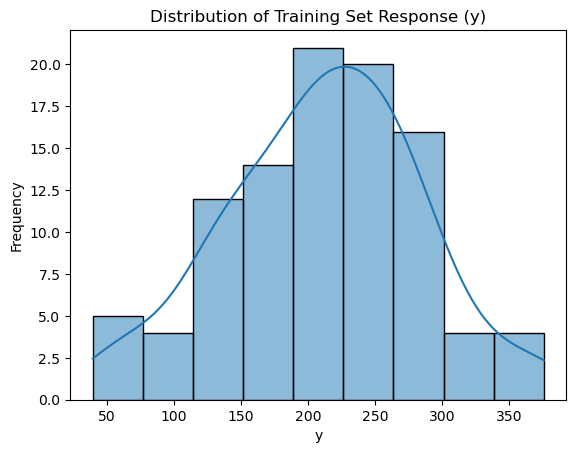

Training set observations: 100
Number of predictors: 100


In [21]:

# -----------------------------------------------------
# 1) LOAD AND INSPECT THE TRAINING DATA (case1Data.csv)
# -----------------------------------------------------
train_data = pd.read_csv('case1Data.csv')
print("Training data shape:", train_data.shape)

# The first column is 'y', the target; remaining columns are features
y_train = train_data.iloc[:, 0]
X_train_raw = train_data.iloc[:, 1:]

# Quick look at distribution of Y
sns.histplot(y_train, kde=True)
plt.title('Distribution of Training Set Response (y)')
plt.xlabel('y')
plt.ylabel('Frequency')
plt.show()

n, p = X_train_raw.shape
print("Training set observations:", n)
print("Number of predictors:", p)

In [22]:

# -----------------------------------------------------
# 2) LOAD AND INSPECT THE NEW DATA (case1Data_Xnew.csv)
# -----------------------------------------------------
new_data = pd.read_csv('case1Data_Xnew.csv')
print("New data shape:", new_data.shape)

X_new_raw = new_data.iloc[:,:]
n_new, p_new = X_new_raw.shape
print("New data observations:", n_new)
print("Number of predictors (new):", p_new)


New data shape: (1000, 100)
New data observations: 1000
Number of predictors (new): 100


In [24]:
X_new_raw

,x_01,x_02,x_03,x_04,x_05,x_06,x_07,x_08,x_09,x_10,...,x_91,x_92,x_93,x_94,x_95,C_01,C_02,C_03,C_04,C_05
0,-0.843969,-9.104918,-5.076919,-4.222152,3.606609,-4.505494,-11.481997,16.201722,15.939470,NaN,...,-13.884702,7.465161,-4.667464,3.949705,-10.715577,73.0,72.0,73.0,75.0,73.0
1,0.802093,-10.196678,-4.500370,-7.827837,5.199002,NaN,-15.928708,20.151309,13.707194,-8.517576,...,-14.937164,5.229448,-6.927970,3.271193,-12.420893,73.0,72.0,73.0,71.0,75.0
2,4.234883,-10.798261,-0.465914,-6.054850,NaN,NaN,-16.182312,16.419564,12.152861,-6.418069,...,-11.058964,4.692879,-0.929818,NaN,-14.551448,NaN,72.0,73.0,71.0,73.0
3,7.041336,-5.169413,-4.158334,-4.270638,14.939894,0.008338,-10.556799,NaN,14.180830,NaN,...,NaN,7.460901,-2.484389,8.149697,-11.598544,72.0,72.0,74.0,75.0,75.0
4,1.135564,-12.048088,-4.828939,-6.565217,7.493100,-2.789944,-15.859234,21.560086,14.147759,-4.848519,...,-9.607803,5.654679,-3.020357,3.030958,-13.320599,72.0,72.0,71.0,74.0,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,-10.333885,-4.882893,-5.001330,14.740750,-7.375751,-14.269895,NaN,18.944182,-3.516163,...,-15.231878,NaN,NaN,2.773400,-8.033125,73.0,72.0,71.0,74.0,NaN
996,-0.301550,-9.275305,NaN,-9.984508,5.443650,-5.003200,-13.199856,22.410145,12.723149,-5.684371,...,-13.423383,4.090021,-5.349963,3.544913,-10.234976,72.0,72.0,73.0,74.0,NaN
997,3.671630,-6.533390,-0.489830,-5.143861,13.761843,-8.637093,NaN,24.973347,13.576836,-3.389953,...,-10.147875,8.668706,-4.411021,-0.860737,-7.109857,72.0,72.0,71.0,75.0,NaN
998,2.356294,-4.169392,-2.274090,-2.484517,10.591025,2.055309,-9.804748,15.946822,11.053100,-3.986907,...,-11.107330,4.475155,-2.621623,8.438770,-7.255016,72.0,72.0,71.0,71.0,73.0


In [57]:

# -----------------------------------------------------
# 3) STANDARD SCALING (TRAIN + NEW)
#    We'll do it once for train, once for new data
# -----------------------------------------------------

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_raw),
                              columns=X_train_raw.columns)

y_train_scaled = pd.Series(scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten())

X_new_scaled   = pd.DataFrame(scaler.fit_transform(X_new_raw),
                              columns=X_new_raw.columns)

In [26]:
# -----------------------------------------------------
# 4) CHECK MISSING VALUES ON THE TRAINING DATA
#    (We do not forcibly show the same for new_data, but you can do so similarly)
# -----------------------------------------------------
missing_values = X_train_scaled.isnull().sum()
print("\nMissing values in each TRAIN column:\n", missing_values)
rows_with_missing_data = X_train_scaled.isnull().any(axis=1).sum()
print("Number of training rows with missing data:", rows_with_missing_data)
total_missing = missing_values.sum()
total_missing_percentage = total_missing / (X_train_scaled.shape[0] * X_train_scaled.shape[1]) * 100
print("Total missing in TRAIN:", total_missing)
print(f"Total % missing in TRAIN: {total_missing_percentage:.2f}%")

# For demonstration, we show naive row/column drop (not recommended)
print("\nDropping rows with missing (train):", X_train_scaled.dropna().shape)
print("Dropping columns with missing (train):", X_train_scaled.dropna(axis=1).shape)


Missing values in each TRAIN column:
 x_01    13
x_02    21
x_03    15
x_04    14
x_05    12
        ..
C_01    22
C_02    22
C_03    22
C_04    22
C_05    22
Length: 100, dtype: int64
Number of training rows with missing data: 100
Total missing in TRAIN: 1489
Total % missing in TRAIN: 14.89%

Dropping rows with missing (train): (0, 100)
Dropping columns with missing (train): (100, 0)


In [27]:
# -----------------------------------------------------
# 5) IMPUTE NUMERIC + CATEGORICAL FEATURES FOR TRAIN
#    We assume the last 5 columns are categorical.
#    We'll do "mean" for numeric, "most_frequent" for categorical.
#    Then we choose to do "one-hot" for categoricals, since that performed better.
# -----------------------------------------------------

cat_cols = X_train_scaled.columns[-5:].tolist()
num_cols = [c for c in X_train_scaled.columns if c not in cat_cols]

# Impute numeric
num_imputer = SimpleImputer(strategy='mean')
X_num_imputed_train = num_imputer.fit_transform(X_train_scaled[num_cols])

# Impute categorical
cat_imputer = SimpleImputer(strategy='most_frequent')
X_cat_imputed_train = cat_imputer.fit_transform(X_train_scaled[cat_cols])

# One-hot encode the imputed categorical data
ohe = OneHotEncoder(handle_unknown='ignore')
X_cat_onehot_train = ohe.fit_transform(X_cat_imputed_train).toarray()

# Combine numeric + one-hot
X_train_preprocessed = np.hstack([X_num_imputed_train, X_cat_onehot_train])

In [32]:
# -----------------------------------------------------
# 6) REPEAT THE SAME IMPUTATION + ENCODING FOR NEW DATA
# -----------------------------------------------------

cat_cols_new = X_new_scaled.columns[-5:].tolist()
num_cols_new = [c for c in X_new_scaled.columns if c not in cat_cols_new]

X_num_imputed_new = num_imputer.transform(X_new_scaled[num_cols_new])
X_cat_imputed_new = cat_imputer.transform(X_new_scaled[cat_cols_new])
X_cat_onehot_new  = ohe.transform(X_cat_imputed_new).toarray()

X_new_preprocessed = np.hstack([X_num_imputed_new, X_cat_onehot_new])

In [33]:
# -----------------------------------------------------
# 7) MEAN VS. MEDIAN IMPUTATION (OPTIONAL COMPARISON)
#    Illustrating your cross-validation approach. We'll do it only on the train set.
# -----------------------------------------------------
print("\nComparing mean vs. median imputation on numeric columns:")

median_imputer = SimpleImputer(strategy='median')

# For the numeric columns only:
X_median_imputed_train = median_imputer.fit_transform(X_train_scaled[num_cols])

# Let's do a quick CV with Lasso
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso

lasso_demo = Lasso(alpha=0.01)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate mean-imputed numeric data
scores_mean = cross_val_score(lasso_demo, X_num_imputed_train, y_train_scaled, cv=cv,
                              scoring='neg_mean_squared_error')
mse_mean = -scores_mean
print("Mean-imputed MSE:", mse_mean.mean(), "+/-", mse_mean.std())

# Evaluate median-imputed numeric data
scores_median = cross_val_score(lasso_demo, X_median_imputed_train, y_train_scaled, cv=cv,
                                scoring='neg_mean_squared_error')
mse_median = -scores_median
print("Median-imputed MSE:", mse_median.mean(), "+/-", mse_median.std())

# Decide winner (just for demonstration)
if mse_mean.mean() < mse_median.mean():
    print("Mean Imputation yields a lower average MSE.")
else:
    print("Median Imputation yields a lower average MSE.")


Comparing mean vs. median imputation on numeric columns:
Mean-imputed MSE: 0.19796933918662685 +/- 0.03946051081771772
Median-imputed MSE: 0.20827570483910166 +/- 0.038661255444917025
Mean Imputation yields a lower average MSE.


In [45]:

# -----------------------------------------------------
# 8) FULL MODEL SELECTION (Ridge, Lasso, ENet, RF, GB, Ada)
#    Using the final "one-hot" approach from above
# -----------------------------------------------------

X_train_pp = X_train_preprocessed  # numeric+one-hot
y_train_pp = y_train_scaled

param_grid_ridge = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
param_grid_lasso = {'alpha': [0.012, 0.015, 0.018, 0.02, 0.03, 0.05, 0.1]}
param_grid_enet  = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.001, 0.1, 0.3, 0.5, 0.7, 0.9]
}
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10]
}
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5]
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = 'neg_mean_squared_error'

from sklearn.model_selection import GridSearchCV
grid_ridge = GridSearchCV(Ridge(), param_grid_ridge, scoring=scoring, cv=cv, n_jobs=-1)
grid_lasso = GridSearchCV(Lasso(), param_grid_lasso, scoring=scoring, cv=cv, n_jobs=-1)
grid_enet  = GridSearchCV(ElasticNet(), param_grid_enet, scoring=scoring, cv=cv, n_jobs=-1)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, scoring=scoring, cv=cv, n_jobs=-1)
grid_gb = GridSearchCV(GradientBoostingRegressor(), param_grid_gb, scoring=scoring, cv=cv, n_jobs=-1)
grid_ada = GridSearchCV(AdaBoostRegressor(), param_grid_ada, scoring=scoring, cv=cv, n_jobs=-1)

# Fit each
grid_ridge.fit(X_train_pp, y_train_pp)
grid_lasso.fit(X_train_pp, y_train_pp)
grid_enet.fit(X_train_pp, y_train_pp)
grid_rf.fit(X_train_pp, y_train_pp)
grid_gb.fit(X_train_pp, y_train_pp)
grid_ada.fit(X_train_pp, y_train_pp)

def cv_mse_to_positive(gscv):
    return -gscv.best_score_

print("\n--- CROSS-VALIDATION RESULTS ---")
print("RIDGE  MSE:", cv_mse_to_positive(grid_ridge), "params:", grid_ridge.best_params_)
print("LASSO  MSE:", cv_mse_to_positive(grid_lasso), "params:", grid_lasso.best_params_)
print("ENET   MSE:", cv_mse_to_positive(grid_enet),  "params:", grid_enet.best_params_)
print("RF     MSE:", cv_mse_to_positive(grid_rf),    "params:", grid_rf.best_params_)
print("GB     MSE:", cv_mse_to_positive(grid_gb),    "params:", grid_gb.best_params_)
print("ADA    MSE:", cv_mse_to_positive(grid_ada),   "params:", grid_ada.best_params_)

model_results = [
    ("Ridge",        cv_mse_to_positive(grid_ridge)),
    ("Lasso",        cv_mse_to_positive(grid_lasso)),
    ("ElasticNet",   cv_mse_to_positive(grid_enet)),
    ("RandomForest", cv_mse_to_positive(grid_rf)),
    ("GradientBoosting", cv_mse_to_positive(grid_gb)),
    ("AdaBoost",     cv_mse_to_positive(grid_ada))
]
model_results.sort(key=lambda x: x[1])
print("\nMODEL PERFORMANCE (sorted by best CV MSE):")
for name, mse in model_results:
    print(f"{name}: {mse:.4f}")

best_model_name, best_mse = model_results[0]
print(f"\nBEST MODEL: {best_model_name} with CV MSE={best_mse:.4f}")

# Pick that best model for the final fit
if best_model_name == "Ridge":
    final_model = Ridge(**grid_ridge.best_params_)
elif best_model_name == "Lasso":
    final_model = Lasso(**grid_lasso.best_params_)
elif best_model_name == "ElasticNet":
    final_model = ElasticNet(**grid_enet.best_params_)
elif best_model_name == "RandomForest":
    final_model = RandomForestRegressor(**grid_rf.best_params_)
elif best_model_name == "GradientBoosting":
    final_model = GradientBoostingRegressor(**grid_gb.best_params_)
else:
    final_model = AdaBoostRegressor(**grid_ada.best_params_)

# Retrain on the FULL training set
final_model.fit(X_train_pp, y_train_pp)



--- CROSS-VALIDATION RESULTS ---
RIDGE  MSE: 0.21883328408898034 params: {'alpha': 1.0}
LASSO  MSE: 0.19538341206242765 params: {'alpha': 0.015}
ENET   MSE: 0.20267980757288312 params: {'alpha': 0.01, 'l1_ratio': 0.5}
RF     MSE: 0.3608881843722428 params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
GB     MSE: 0.3462641630468891 params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
ADA    MSE: 0.3736124921208071 params: {'learning_rate': 0.5, 'n_estimators': 50}

MODEL PERFORMANCE (sorted by best CV MSE):
Lasso: 0.1954
ElasticNet: 0.2027
Ridge: 0.2188
GradientBoosting: 0.3463
RandomForest: 0.3609
AdaBoost: 0.3736

BEST MODEL: Lasso with CV MSE=0.1954


Lasso(alpha=0.015)

In [48]:

# -----------------------------------------------------
# 9) OPTIONAL: UNIVARIATE FEATURE SELECTION
#    (Bonferroni / FDR correction).
# -----------------------------------------------------
p = 100
PValues = np.zeros(p)
Xsub = np.zeros(p)
for j in range(p):
    Xsub = X_train_pp[:,j]
    slope, intercept, r_value, PValues[j], std_err = linregress(Xsub, y_train_pp)

# Sort p-values in acending order
idx1 = np.argsort(PValues)
p = PValues[idx1]

remaining_features_bonf = len(np.where(p < (0.05 / 2016))[0]) # Amount af features included
print(f'Remaining features after correcting with Bonferroni correction: {remaining_features_bonf}.')

Remaining features after correcting with Bonferroni correction: 2.


In [49]:
FDR = multipletests(PValues, alpha = 0.05, method = "fdr_bh")[1] # Computing Benjamini Hochberg's FDR

idx2 = np.argsort(FDR)
fdr = FDR[idx2]

remaining_features_fdr = len(np.where(fdr < 0.25)[0]) # How many values are below 0.15?
print(f'Remaining features after applying DFR: {remaining_features_fdr}.')

Remaining features after applying DFR: 53.


In [50]:
FDR = multipletests(PValues, alpha = 0.05, method = "fdr_bh")[1] # Computing Benjamini Hochberg's FDR

idx2 = np.argsort(FDR)
fdr = FDR[idx2]

remaining_features_fdr = len(np.where(fdr < 0.15)[0]) # How many values are below 0.15?
print(f'Remaining features after applying DFR: {remaining_features_fdr}.')

Remaining features after applying DFR: 41.


In [64]:
#REDIFINE THE NEW DATASET WITH THE SELECTED FEATURES
X_final_53= X_train_pp[:, idx2[:53]]
y_train = y_train_pp


#  CHOOSE A CROSS-VALIDATION STRATEGY
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 4) DEFINE PARAMETER GRIDS
param_grid_ridge = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
param_grid_lasso = {'alpha': [0.03, 0.035,0.04,0.045, 0.05, 0.08, 0.1, 0.2]}
param_grid_enet = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.001, 0.1, 0.3, 0.5, 0.7, 0.9]
}
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10]
}

param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5]
}

# 5) SET UP GRIDSEARCHCV FOR EACH MODEL
grid_ridge = GridSearchCV(
    estimator=Ridge(),
    param_grid=param_grid_ridge,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)

grid_lasso = GridSearchCV(
    estimator=Lasso(),
    param_grid=param_grid_lasso,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)

grid_enet = GridSearchCV(
    estimator=ElasticNet(),
    param_grid=param_grid_enet,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)

grid_rf = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)

grid_gb = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid=param_grid_gb,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)

grid_ada = GridSearchCV(
    estimator=AdaBoostRegressor(),
    param_grid=param_grid_ada,
    scoring='neg_mean_squared_error',
    cv=cv,
    n_jobs=-1
)
# 6) FIT EACH GRID SEARCH
grid_ridge.fit(X_final_53, y_train)
grid_lasso.fit(X_final_53, y_train)
grid_enet.fit(X_final_53, y_train)
grid_rf.fit(X_final_53, y_train)
grid_gb.fit(X_final_53, y_train)
grid_ada.fit(X_final_53, y_train)

# 7) INSPECT RESULTS AND COMPARE
print("RIDGE BEST PARAMS:", grid_ridge.best_params_)
print("RIDGE BEST CV MSE:", -grid_ridge.best_score_)

print("LASSO BEST PARAMS:", grid_lasso.best_params_)
print("LASSO BEST CV MSE:", -grid_lasso.best_score_)

print("ENET BEST PARAMS:", grid_enet.best_params_)
print("ENET BEST CV MSE:", -grid_enet.best_score_)

print("RF BEST PARAMS:", grid_rf.best_params_)
print("RF BEST CV MSE:", -grid_rf.best_score_)

print("GB BEST PARAMS:", grid_gb.best_params_)
print("GB BEST CV MSE:", -grid_gb.best_score_)

print("ADA BEST PARAMS:", grid_ada.best_params_)
print("ADA BEST CV MSE:", -grid_ada.best_score_)

# 8) CHOOSE THE BEST MODEL OVERALL
best_mse_ridge = -grid_ridge.best_score_
best_mse_lasso = -grid_lasso.best_score_
best_mse_enet  = -grid_enet.best_score_
best_mse_rf = -grid_rf.best_score_
best_mse_gb = -grid_gb.best_score_
best_mse_ada = -grid_ada.best_score_

model_mses = [('Ridge', best_mse_ridge),
              ('Lasso', best_mse_lasso),
              ('ElasticNet', best_mse_enet),
              ('RandomForest', best_mse_rf),
              ('GradientBoosting', best_mse_gb),
              ('AdaBoost', best_mse_ada)]

model_mses.sort(key=lambda x: x[1])
print("\nMODEL PERFORMANCE (sorted by best CV MSE):")
for name, mse in model_mses:
    print(f"{name}: MSE={mse:.4f}")

best_model_name, best_model_mse = model_mses[0]
print(f"\nBEST MODEL: {best_model_name} with MSE={best_model_mse:.4f}")

# 9) RETRAIN ON ALL DATA (OPTIONAL)
if best_model_name == "Ridge":
    final_model = Ridge(**grid_ridge.best_params_)
elif best_model_name == "Lasso":
    final_model = Lasso(**grid_lasso.best_params_)
elif best_model_name == "ElasticNet":
    final_model = ElasticNet(**grid_enet.best_params_)
elif best_model_name == "RandomForest":
    final_model = RandomForestRegressor(**grid_rf.best_params_)
elif best_model_name == "GradientBoosting":
    final_model = GradientBoostingRegressor(**grid_gb.best_params_)
else:  # "AdaBoost"
    final_model = AdaBoostRegressor(**grid_ada.best_params_)


final_model.fit(X_final_53, y_train)
# Now use `final_model.predict(X_new)` to get predictions


RIDGE BEST PARAMS: {'alpha': 10.0}
RIDGE BEST CV MSE: 0.32066051075937374
LASSO BEST PARAMS: {'alpha': 0.04}
LASSO BEST CV MSE: 0.20958744198951748
ENET BEST PARAMS: {'alpha': 0.1, 'l1_ratio': 0.3}
ENET BEST CV MSE: 0.2287232214785095
RF BEST PARAMS: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
RF BEST CV MSE: 0.35321509824629116
GB BEST PARAMS: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
GB BEST CV MSE: 0.34141916566395436
ADA BEST PARAMS: {'learning_rate': 0.01, 'n_estimators': 200}
ADA BEST CV MSE: 0.3655311102645689

MODEL PERFORMANCE (sorted by best CV MSE):
Lasso: MSE=0.2096
ElasticNet: MSE=0.2287
Ridge: MSE=0.3207
GradientBoosting: MSE=0.3414
RandomForest: MSE=0.3532
AdaBoost: MSE=0.3655

BEST MODEL: Lasso with MSE=0.2096


Lasso(alpha=0.04)

# FIT THE FINAL MODEL IN X_NEW


Predictions on new data: (1000,)


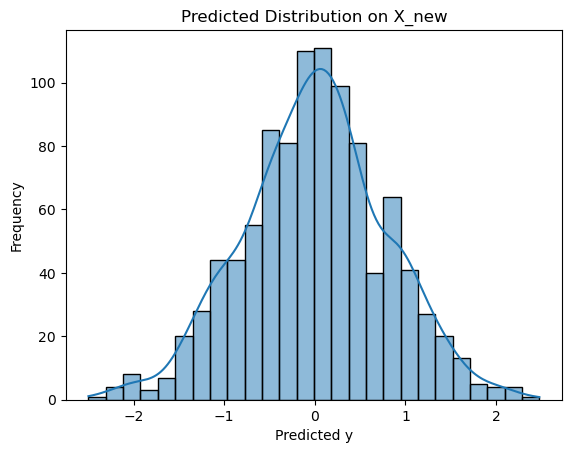

In [53]:
# -----------------------------------------------------
# 10) PREDICT ON X_new  (the "unseen" data)
# WE'RE FINALLY USING THE LAST MODEL, LASSO WITH ALPHA=0.04 AND WITH ONLY 53 FEATURES
# -----------------------------------------------------
#we need to select the 53 features from the new data as well
X_new_final = X_new_preprocessed[:, idx2[:53]]

y_pred_new = final_model.predict(X_new_final)
print(f"\nPredictions on new data: {y_pred_new.shape}")

# Quick check distribution
sns.histplot(y_pred_new, kde=True)
plt.title('Predicted Distribution on X_new')
plt.xlabel('Predicted y')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# -----------------------------------------------------
# 11) ESTIMATE OF UNCERTAINTY
#    If you want a rough measure of variability in predictions
# -----------------------------------------------------
n_boot = 1000
all_preds = np.zeros((n_boot, len(y_pred_new)))
for i in range(n_boot):
    idx_samp = np.random.choice(len(y_pred_new), len(y_pred_new), replace=True)
    all_preds[i] = y_pred_new[idx_samp]

std_each = np.std(all_preds, axis=0)
mean_std = np.mean(std_each)
ci_lower = np.percentile(all_preds, 2.5, axis=0)
ci_upper = np.percentile(all_preds, 97.5, axis=0)
mean_lower = np.mean(ci_lower)
mean_upper = np.mean(ci_upper)

print(f"Average prediction std across new data points: {mean_std:.4f}")
print(f"95% CI for predictions (averaged): ({mean_lower:.4f}, {mean_upper:.4f})")


Average prediction std across new data points: 0.7866
95% CI for predictions (averaged): (-1.5203, 1.5141)


In [58]:
# -----------------------------------------------------
# 12) RESCALE THE Y PREDICTIONS BACK TO ORIGINAL SCALE
# -----------------------------------------------------
scaler.fit(y_train.values.reshape(-1, 1))  # Fit the scaler on the original training target
y_pred_new_rescaled = scaler.inverse_transform(y_pred_new.reshape(-1, 1)).flatten()
print(f"Rescaled predictions shape: {y_pred_new_rescaled.shape}")

Rescaled predictions shape: (1000,)


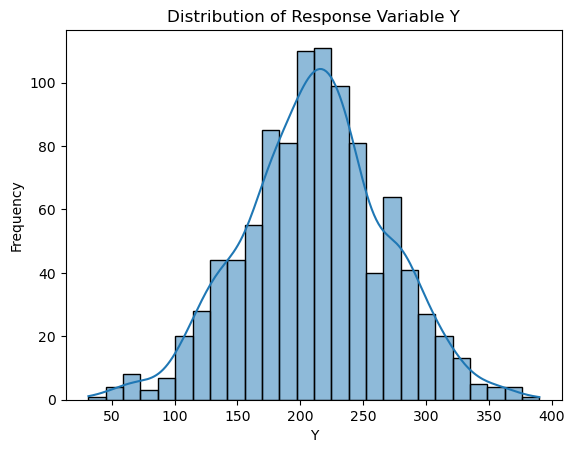

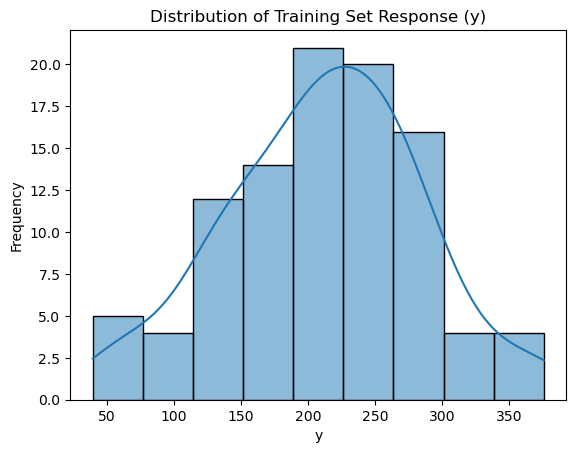

In [62]:
# Visualize the distribution of the response variable Y
sns.histplot(y_pred_new_rescaled, kde=True)
plt.title('Distribution of Response Variable Y')
plt.xlabel('Y')
plt.ylabel('Frequency')
plt.show()

# Quick look at distribution of Y_train
sns.histplot(y_train, kde=True)
plt.title('Distribution of Training Set Response (y)')
plt.xlabel('y')
plt.ylabel('Frequency')
plt.show()

# RMSE ESTIMATE

In [69]:
# final_model: your chosen & configured model, e.g. Lasso(alpha=0.01)
# X_preprocessed: final feature matrix (already imputed, encoded, scaled)
# y: target values

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validate, measuring negative MSE
scores = cross_val_score(final_model, X_final_53, y_train,
                         cv=cv, scoring='neg_mean_squared_error')

# Convert from negative MSE to positive MSE
mse_cv = -scores.mean()

# Estimate RMSE
rmse_estimate = np.sqrt(mse_cv)
print(f"Estimated RMSE from CV: {rmse_estimate:.4f}")


Estimated RMSE from CV: 0.4578


## Estimated RMSE from CV: 0.4578